In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
img_size = 224
batch_size = 64
num_classes = 27
learning_rate = 3e-4
EPOCHS = 30

In [3]:
train_dir = 'RSCD/RSCD_dataset/train_50k'
val_dir = 'RSCD/RSCD_dataset/validation'
test_dir = 'RSCD/RSCD_dataset/test'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


In [4]:
class AlbumentationsDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.classes = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d)) and d != ".DS_Store"
        ])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []
        for cls in self.classes:
            cls_path = os.path.join(root_dir, cls)
            for img in os.listdir(cls_path):
                if img.lower().endswith(('jpg', 'jpeg', 'png')) and img != ".DS_Store":
                    self.image_paths.append(os.path.join(cls_path, img))
                    self.labels.append(self.class_to_idx[cls])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Failed to load image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented = self.transform(image=image)
        return augmented['image'], torch.tensor(label)

In [5]:
train_transform = A.Compose([
    A.RandomResizedCrop((img_size, img_size), scale=(0.85, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.MotionBlur(p=0.2),
    A.RandomShadow(p=0.2),
    A.RandomRain(p=0.1),
    A.RandomSnow(p=0.1),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [6]:
train_dataset = AlbumentationsDataset(train_dir, train_transform)
val_dataset = AlbumentationsDataset(val_dir, val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [7]:
weights = ConvNeXt_Base_Weights.DEFAULT
model = convnext_base(weights=weights)

In [8]:
for param in model.features.parameters():
    param.requires_grad = False

In [9]:
num_features = model.classifier[2].in_features
model.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),                
    nn.Flatten(),                                
    nn.LayerNorm(num_features),                 
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 27)                          
)

In [10]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.classifier.apply(init_weights)
model = model.to(device)

In [11]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=learning_rate, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

In [12]:
best_acc = 0.0
train_loss = []
train_accu = []
val_accu = []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    scheduler.step()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    train_loss.append(running_loss)
    train_accu.append(train_acc)

    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.4f}")
    val_accu.append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_convnext_model.pth")
        print("Best model saved!")

print(f"\nTraining completed. Best validation accuracy: {best_acc:.4f}")

Epoch 1/30: 100%|█████████████████████████████████████████████████████████████████| 21094/21094 [56:34<00:00,  6.21it/s]

Epoch 1, Loss: 39554.4715, Train Accuracy: 0.5167


Validation Accuracy: 0.6283
Best model saved!


Epoch 2/30: 100%|█████████████████████████████████████████████████████████████████| 21094/21094 [56:30<00:00,  6.22it/s]

Epoch 2, Loss: 37404.2162, Train Accuracy: 0.5552


Validation Accuracy: 0.6558
Best model saved!


Epoch 3/30: 100%|█████████████████████████████████████████████████████████████████| 21094/21094 [56:34<00:00,  6.21it/s]

Epoch 3, Loss: 36803.3629, Train Accuracy: 0.5652


Validation Accuracy: 0.6648
Best model saved!


Epoch 4/30: 100%|█████████████████████████████████████████████████████████████████| 21094/21094 [56:34<00:00,  6.21it/s]

Epoch 4, Loss: 36468.5614, Train Accuracy: 0.5703


Validation Accuracy: 0.6727
Best model saved!


Epoch 5/30: 100%|█████████████████████████████████████████████████████████████████| 21094/21094 [56:34<00:00,  6.21it/s]

Epoch 5, Loss: 36272.5162, Train Accuracy: 0.5733


Validation Accuracy: 0.6734
Best model saved!


Epoch 6/30: 100%|█████████████████████████████████████████████████████████████████| 21094/21094 [56:31<00:00,  6.22it/s]

Epoch 6, Loss: 36134.6708, Train Accuracy: 0.5757


Validation Accuracy: 0.6713


Epoch 7/30: 100%|█████████████████████████████████████████████████████████████████| 21094/21094 [56:30<00:00,  6.22it/s]

Epoch 7, Loss: 36036.9760, Train Accuracy: 0.5775


Validation Accuracy: 0.6716


Epoch 8/30: 100%|█████████████████████████████████████████████████████████████████| 21094/21094 [56:29<00:00,  6.22it/s]

Epoch 8, Loss: 35952.6398, Train Accuracy: 0.5795


Validation Accuracy: 0.6777
Best model saved!


Epoch 9/30: 100%|█████████████████████████████████████████████████████████████████| 21094/21094 [56:26<00:00,  6.23it/s]

Epoch 9, Loss: 35881.5499, Train Accuracy: 0.5798


Validation Accuracy: 0.6798
Best model saved!


Epoch 10/30: 100%|████████████████████████████████████████████████████████████████| 21094/21094 [56:30<00:00,  6.22it/s]

Epoch 10, Loss: 35806.6552, Train Accuracy: 0.5819


Validation Accuracy: 0.6808
Best model saved!


Epoch 11/30: 100%|████████████████████████████████████████████████████████████████| 21094/21094 [56:31<00:00,  6.22it/s]

Epoch 11, Loss: 35717.4875, Train Accuracy: 0.5836


Validation Accuracy: 0.6829
Best model saved!


Epoch 12/30: 100%|████████████████████████████████████████████████████████████████| 21094/21094 [56:27<00:00,  6.23it/s]

Epoch 12, Loss: 35661.1955, Train Accuracy: 0.5841


Validation Accuracy: 0.6856
Best model saved!


Epoch 13/30: 100%|████████████████████████████████████████████████████████████████| 21094/21094 [59:07<00:00,  5.95it/s]

Epoch 13, Loss: 35556.4648, Train Accuracy: 0.5860


Validation Accuracy: 0.6868
Best model saved!


Epoch 14/30: 100%|████████████████████████████████████████████████████████████████| 21094/21094 [56:37<00:00,  6.21it/s]

Epoch 14, Loss: 35476.4254, Train Accuracy: 0.5877


Validation Accuracy: 0.6869
Best model saved!


Epoch 15/30: 100%|████████████████████████████████████████████████████████████████| 21094/21094 [57:01<00:00,  6.16it/s]

Epoch 15, Loss: 35404.2558, Train Accuracy: 0.5885


Validation Accuracy: 0.6859


Epoch 16/30: 100%|██████████████████████████████████████████████████████████████| 21094/21094 [1:02:26<00:00,  5.63it/s]

Epoch 16, Loss: 35311.2396, Train Accuracy: 0.5905


Validation Accuracy: 0.6900
Best model saved!


Epoch 17/30: 100%|████████████████████████████████████████████████████████████████| 21094/21094 [56:33<00:00,  6.22it/s]

Epoch 17, Loss: 35233.9779, Train Accuracy: 0.5920


Validation Accuracy: 0.6893


Epoch 18/30: 100%|████████████████████████████████████████████████████████████████| 21094/21094 [56:58<00:00,  6.17it/s]

Epoch 18, Loss: 35140.0735, Train Accuracy: 0.5937


Validation Accuracy: 0.6904
Best model saved!


Epoch 19/30: 100%|████████████████████████████████████████████████████████████████| 21094/21094 [57:00<00:00,  6.17it/s]

Epoch 19, Loss: 35053.8249, Train Accuracy: 0.5951


Validation Accuracy: 0.6965
Best model saved!


Epoch 20/30: 100%|████████████████████████████████████████████████████████████████| 21094/21094 [57:31<00:00,  6.11it/s]

Epoch 20, Loss: 34960.4061, Train Accuracy: 0.5973


Validation Accuracy: 0.6968
Best model saved!


Epoch 21/30:  67%|██████████████████████████████████████████▋                     | 14085/21094 [37:44<18:46,  6.22it/s]


KeyboardInterrupt: 

In [1]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
import torch.nn as nn

img_size = 224
batch_size = 64
num_classes = 27
test_dir = 'RSCD/RSCD_dataset/test'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

val_test_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

def extract_label_from_filename(filename):
    name = os.path.splitext(filename)[0]
    label = name.split('-', 1)[1]
    return label

all_labels = set()
for fname in os.listdir(test_dir):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        label = extract_label_from_filename(fname)
        all_labels.add(label)
label_to_idx = {label: idx for idx, label in enumerate(sorted(all_labels))}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

class FlatFolderTestDataset(Dataset):
    def __init__(self, folder, transform):
        self.image_paths = []
        self.labels = []
        for fname in os.listdir(folder):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                label_str = extract_label_from_filename(fname)
                if label_str in label_to_idx:
                    self.image_paths.append(os.path.join(folder, fname))
                    self.labels.append(label_to_idx[label_str])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        transformed = self.transform(image=image)
        return transformed['image'], torch.tensor(label)

test_dataset = FlatFolderTestDataset(test_dir, val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

weights = ConvNeXt_Base_Weights.DEFAULT
model = convnext_base(weights=weights)

for param in model.features.parameters():
    param.requires_grad = False

num_features = model.classifier[2].in_features
model.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.LayerNorm(num_features),
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, num_classes)
)

model.load_state_dict(torch.load("best_convnext_model.pth"))
model = model.to(device)
model.eval()

correct, total = 0, 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on test set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

if total == 0:
    print("No valid test images found.")
else:
    test_accuracy = correct / total
    print(f"\n Test Accuracy: {test_accuracy:.4f} ({correct}/{total})")

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /home/jovyan/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 338M/338M [00:02<00:00, 164MB/s]
Evaluating on test set: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 774/774 [02:04<00:00,  6.23it/s]


 Test Accuracy: 0.7925 (39231/49500)


In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, EPOCHS + 1), train_loss, marker='o', label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Loss vs Epoch.jpg", format='jpg', dpi=300)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(1, EPOCHS + 1), val_accu, marker='s', color='green', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy vs Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Validation vs epoch.jpg", format='jpg', dpi=300)
plt.show()

NameError: name 'EPOCHS' is not defined

<Figure size 600x400 with 0 Axes>

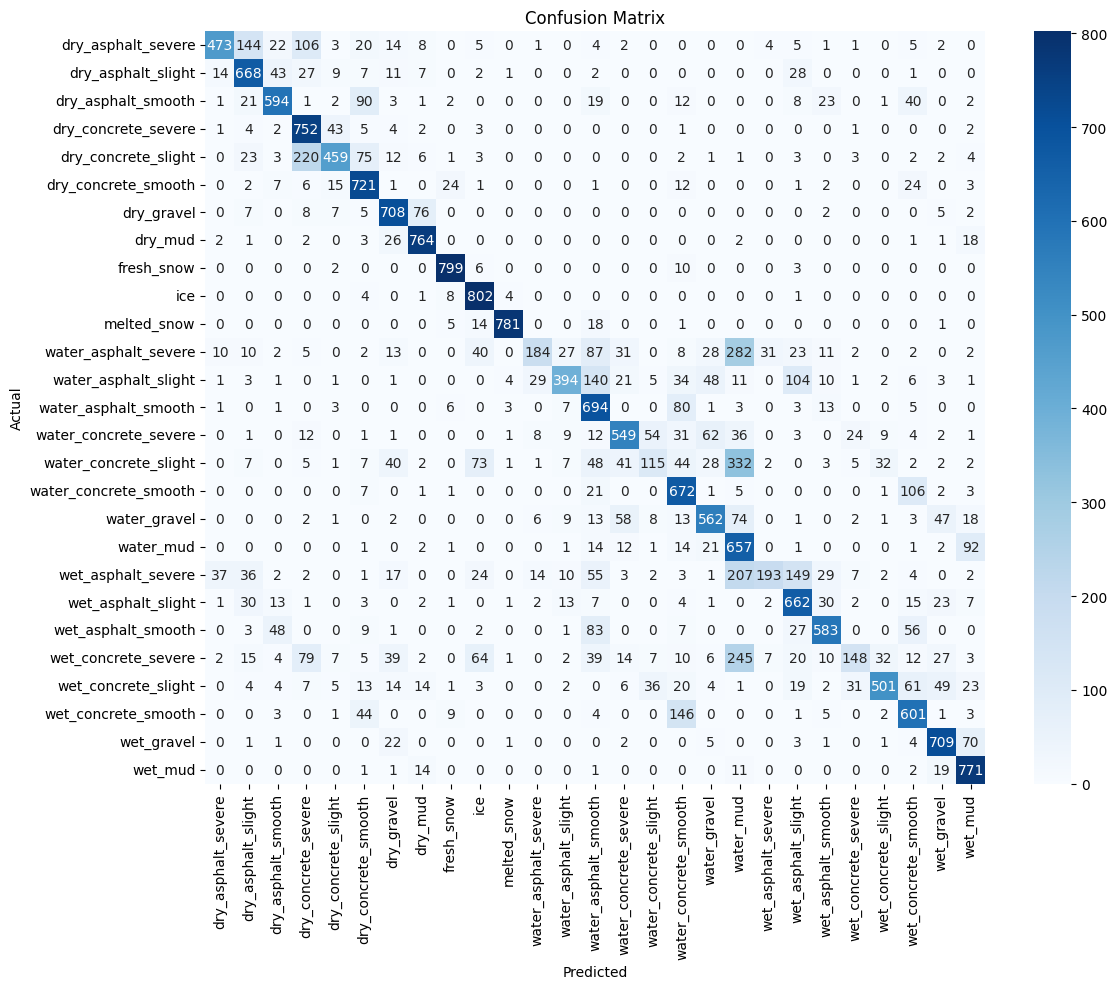

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("Confusion_matrix.jpg", format='jpg', dpi=300)
plt.show()

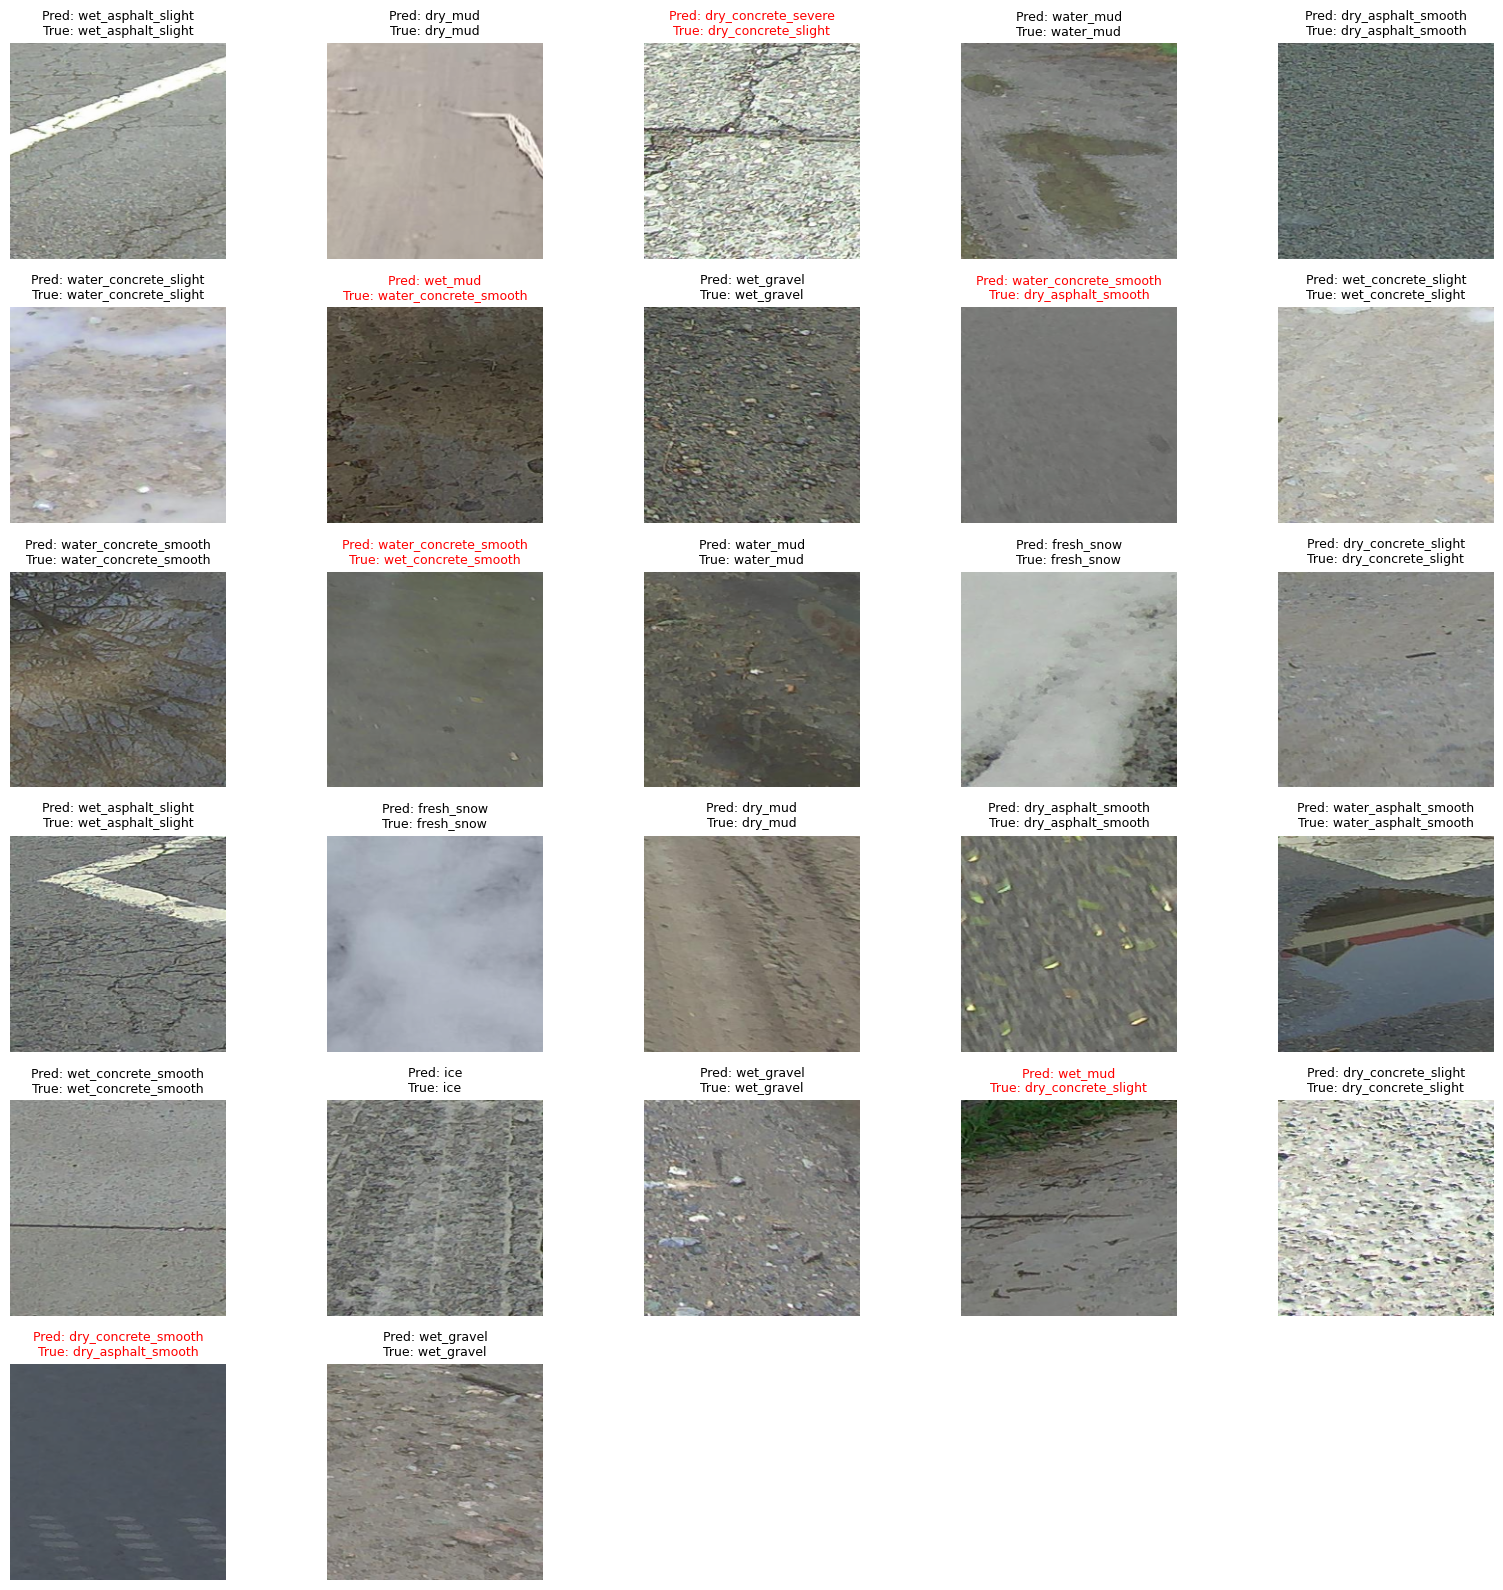

In [20]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import random
import numpy as np

# Ensure model is in eval mode
model.eval()

idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

num_images = 27
indices = random.sample(range(len(test_dataset)), num_images)

# Plotting
plt.figure(figsize=(16, 16))
rows, cols = 6, 5

with torch.no_grad():
    for i, idx in enumerate(indices):
        image, label = test_dataset[idx] 
        input_image = image.unsqueeze(0).to(device)

        output = model(input_image)
        _, pred_label = torch.max(output, 1)

        img_np = image.permute(1, 2, 0).cpu().numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        pred_label_name = idx_to_class[pred_label.item()]
        true_label_name = idx_to_class[label.item()]

        plt.subplot(rows, cols, i+1)
        plt.imshow(img_np)
        color = "red" if pred_label.item() != label.item() else "black"
        plt.title(f"Pred: {pred_label_name}\nTrue: {true_label_name}", fontsize=9, color=color)

        plt.axis('off')

plt.tight_layout()
plt.savefig("Conv_next_50k_image_classification.jpg", format='jpg', dpi=300)
plt.show()

In [2]:
import torch
from sklearn.metrics import classification_report

# Load the best saved model weights
checkpoint_path = "best_convnext_model.pth"  # Ensure path is correct
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

# Lists to collect all predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on test set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Prepare class names for the classification report in proper order
class_names = [label for label, idx in sorted(label_to_idx.items(), key=lambda x: x[1])]

# Generate and print classification report with precision, recall, and f1-score
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print("Classification Report:\n", report)


Evaluating on test set: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 774/774 [01:59<00:00,  6.45it/s]

Classification Report:
                        precision    recall  f1-score   support

   dry-asphalt-severe     0.8584    0.6062    0.7106       800
   dry-asphalt-slight     0.8219    0.8128    0.8173      2350
   dry-asphalt-smooth     0.7750    0.7226    0.7479      2350
  dry-concrete-severe     0.6710    0.9149    0.7742      2350
  dry-concrete-slight     0.8726    0.5277    0.6577      2350
  dry-concrete-smooth     0.7567    0.8694    0.8091      2350
           dry-gravel     0.8450    0.8468    0.8459      2350
              dry-mud     0.8475    0.9226    0.8835      2350
           fresh_snow     0.9350    0.9736    0.9539      2350
                  ice     0.9624    0.9706    0.9665      2350
          melted_snow     0.9872    0.9549    0.9708      2350
 water-asphalt-severe     0.8129    0.4562    0.5845       800
 water-asphalt-slight     0.6411    0.5025    0.5634       800
 water-asphalt-smooth     0.7369    0.8523    0.7904      2350
water-concrete-severe     0.61